## Retial Analytics : Classical Time Series Analysis & Forecasting 

### Loading data from kaggle


In [1]:
# package to access kaggle api
# !pip install kaggle


In [2]:
# Download the  Olist dataset
# import kaggle
# kaggle.api.dataset_download_files('olistbr/brazilian-ecommerce', path='data/', unzip=True)

### Dataset Details:  
Details on the Dataset can be found here - [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce)

This dataset has information for 100 thousand orders from 2016 - 2018 made at multiple marketplaces in Brazil

### Dataset Relationship Diagram


![title](https://i.imgur.com/HRhd2Y0.png)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# load required paackages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import statsmodels.api as sm
import re

import itertools

#### Load dataset

In [5]:
customers = pd.read_csv('data/olist_customers_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')

product_category_translation =  pd.read_csv('data/product_category_name_translation.csv')  #English translation for the products

### Time Series Analysis objective 

The goal of this time series analysis is to forecast the total order level (in volume and monetary value) on olist website for the following:  
- next day order level  
- 7 days order level

### Dataset EDA

the dataset in focus for this time series analysis are:
- orders
- order items

The **sellers** dataset would also be included to see what individual sellers order level are.  

***order_purchase_timestamp*** feature would be used as a measure of the date when the order took place

#### Sellers dataset

In [6]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [7]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [8]:
print('the number of unique sellers is -', sellers.seller_id.nunique())

the number of unique sellers is - 3095


#### a mapping dictionary to replace seller_id with a simple id (seller_simple_id) e.g. seller_1

In [9]:
temp_ids_index = (np.arange(sellers.seller_id.nunique()) + 1)
sellers_simple_ids = np.char.add('seller_', temp_ids_index.astype('str'))

print(sellers_simple_ids)

['seller_1' 'seller_2' 'seller_3' ... 'seller_3093' 'seller_3094'
 'seller_3095']


In [10]:
temp_sellers_ids_dict = dict(zip(
    sellers.seller_id.unique(), 
    sellers_simple_ids))
print()
print(list(temp_sellers_ids_dict.items())[:5])


[('3442f8959a84dea7ee197c632cb2df15', 'seller_1'), ('d1b65fc7debc3361ea86b5f14c68d2e2', 'seller_2'), ('ce3ad9de960102d0677a81f5d0bb7b2d', 'seller_3'), ('c0f3eea2e14555b6faeea3dd58c1b1c3', 'seller_4'), ('51a04a8a6bdcb23deccc82b0b80742cf', 'seller_5')]


### orders related  datasets

In [11]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [12]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [15]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### Merging orders and order_items datasets

In [16]:
orders_merged = order_items.merge(orders, how='left', on='order_id')
orders_merged.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00


In [17]:
orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   customer_id                    112650 non-null  object 
 8   order_status                   112650 non-null  object 
 9   order_purchase_timestamp       112650 non-null  object 
 10  order_approved_at              112635 non-null  object 
 11  order_delivered_carrier_date   111456 non-null  object 
 12  order_delivered_customer_date 

In [18]:
orders_merged.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [19]:
ts_dataset = orders_merged.loc[:,['seller_id',
                              'product_id',
                                'order_id',
                                  'order_item_id',
                                  'price', 'order_status', 'order_purchase_timestamp']]

In [20]:
ts_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   seller_id                 112650 non-null  object 
 1   product_id                112650 non-null  object 
 2   order_id                  112650 non-null  object 
 3   order_item_id             112650 non-null  int64  
 4   price                     112650 non-null  float64
 5   order_status              112650 non-null  object 
 6   order_purchase_timestamp  112650 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 6.9+ MB


In [21]:
print('the number of unqiue products in the orders -', ts_dataset.product_id.nunique())

the number of unqiue products in the orders - 32951


In [22]:
products_ids_index = (np.arange(ts_dataset.product_id.nunique()) + 1)
products_simple_ids = np.char.add('product_', products_ids_index.astype('str'))

print(products_simple_ids)

['product_1' 'product_2' 'product_3' ... 'product_32949' 'product_32950'
 'product_32951']


In [23]:
temp_products_ids_dict = dict(zip(
    ts_dataset.product_id.unique(), 
    products_simple_ids))
print(list(temp_products_ids_dict.items())[:5])

[('4244733e06e7ecb4970a6e2683c13e61', 'product_1'), ('e5f2d52b802189ee658865ca93d83a8f', 'product_2'), ('c777355d18b72b67abbeef9df44fd0fd', 'product_3'), ('7634da152a4610f1595efa32f14722fc', 'product_4'), ('ac6c3623068f30de03045865e4e10089', 'product_5')]


In [24]:
#replace sellers_id with simple id
ts_dataset['seller_simple_id'] =   ts_dataset['seller_id'].map(temp_sellers_ids_dict)

#replace product_id
ts_dataset['product_simple_id'] =   ts_dataset['product_id'].map(temp_products_ids_dict)

ts_dataset = ts_dataset.loc[:,['order_id', 'order_item_id', 'price',
       'order_status', 'order_purchase_timestamp', 'seller_simple_id',
       'product_simple_id']]

print(ts_dataset.info())

ts_dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  112650 non-null  object 
 1   order_item_id             112650 non-null  int64  
 2   price                     112650 non-null  float64
 3   order_status              112650 non-null  object 
 4   order_purchase_timestamp  112650 non-null  object 
 5   seller_simple_id          112650 non-null  object 
 6   product_simple_id         112650 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 6.9+ MB
None


,order_id,order_item_id,price,order_status,order_purchase_timestamp,seller_simple_id,product_simple_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,delivered,2017-09-13 08:59:02,seller_514,product_1
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,delivered,2017-04-26 10:53:06,seller_472,product_2
2,000229ec398224ef6ca0657da4fc703e,1,199.00,delivered,2018-01-14 14:33:31,seller_1825,product_3
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,delivered,2018-08-08 10:00:35,seller_2024,product_4
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,delivered,2017-02-04 13:57:51,seller_1598,product_5


In [25]:
ts_dataset['order_purchase_timestamp'] = pd.to_datetime(ts_dataset['order_purchase_timestamp'] )

#convert index to datetimeindex
ts_dataset = ts_dataset.set_index(pd.DatetimeIndex(
    ts_dataset['order_purchase_timestamp']
     )).drop('order_purchase_timestamp', axis=1)

ts_dataset.head()

,order_id,order_item_id,price,order_status,seller_simple_id,product_simple_id
order_purchase_timestamp,,,,,,
2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,delivered,seller_514,product_1
2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,1,239.90,delivered,seller_472,product_2
2018-01-14 14:33:31,000229ec398224ef6ca0657da4fc703e,1,199.00,delivered,seller_1825,product_3
2018-08-08 10:00:35,00024acbcdf0a6daa1e931b038114c75,1,12.99,delivered,seller_2024,product_4
2017-02-04 13:57:51,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,delivered,seller_1598,product_5


In [26]:
ts_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112650 entries, 2017-09-13 08:59:02 to 2018-06-09 17:00:18
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           112650 non-null  object 
 1   order_item_id      112650 non-null  int64  
 2   price              112650 non-null  float64
 3   order_status       112650 non-null  object 
 4   seller_simple_id   112650 non-null  object 
 5   product_simple_id  112650 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.0+ MB


In [27]:
ts_dataset.head()

,order_id,order_item_id,price,order_status,seller_simple_id,product_simple_id
order_purchase_timestamp,,,,,,
2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,delivered,seller_514,product_1
2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,1,239.90,delivered,seller_472,product_2
2018-01-14 14:33:31,000229ec398224ef6ca0657da4fc703e,1,199.00,delivered,seller_1825,product_3
2018-08-08 10:00:35,00024acbcdf0a6daa1e931b038114c75,1,12.99,delivered,seller_2024,product_4
2017-02-04 13:57:51,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,delivered,seller_1598,product_5


In [28]:
#resample my time series as daily timeseries

ts_daily = ts_dataset.resample('D')['price'].agg(['sum','count'])


ts_daily.columns = ['order_value', 'order_volume']
ts_daily.index.rename('order_date', inplace=True)
ts_daily.head(20)

,order_value,order_volume
order_date,,
2016-09-04,72.89,2
2016-09-05,59.50,1
2016-09-06,0.00,0
2016-09-07,0.00,0
2016-09-08,0.00,0
2016-09-09,0.00,0
2016-09-10,0.00,0
2016-09-11,0.00,0
2016-09-12,0.00,0


In [29]:
ts_daily.sort_values('order_value', ascending=False)

,order_value,order_volume
order_date,,
2017-11-24,152653.74,1366
2017-11-25,60923.48,580
2018-08-06,56427.39,430
2018-05-16,56283.73,406
2018-05-07,54167.48,421
...,...,...
2016-11-27,0.00,0
2016-11-28,0.00,0
2016-11-29,0.00,0


In [30]:
print('total order value for time series - ', ts_daily.order_value.sum())
print()
print('total order value from dataset - ', ts_dataset.price.sum())

total order value for time series -  13591643.700000016

total order value from dataset -  13591643.700000003


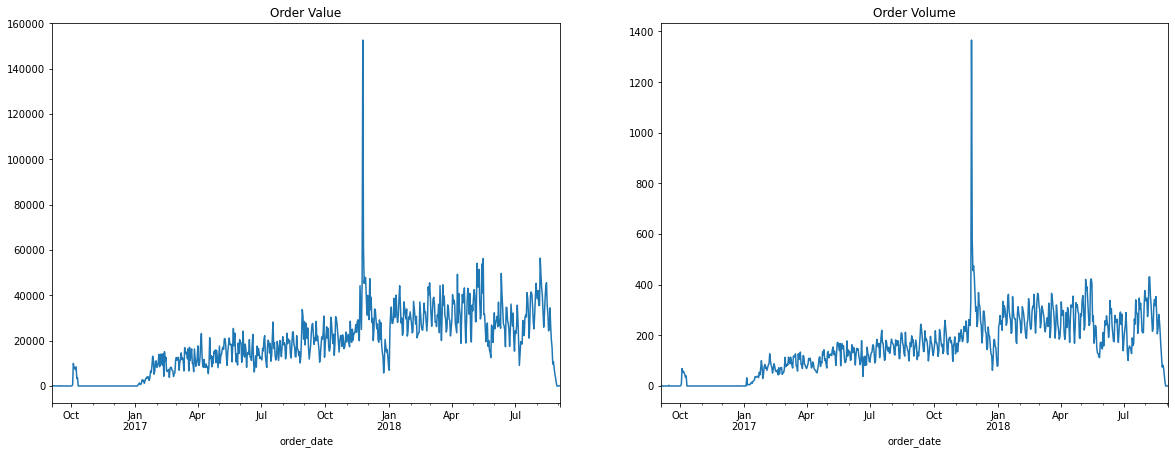

In [31]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1,)
ts_daily.order_value.plot()
plt.title('Order Value');

plt.subplot(1,2,2)
ts_daily.order_volume.plot()
plt.title('Order Volume');

### order level value by period

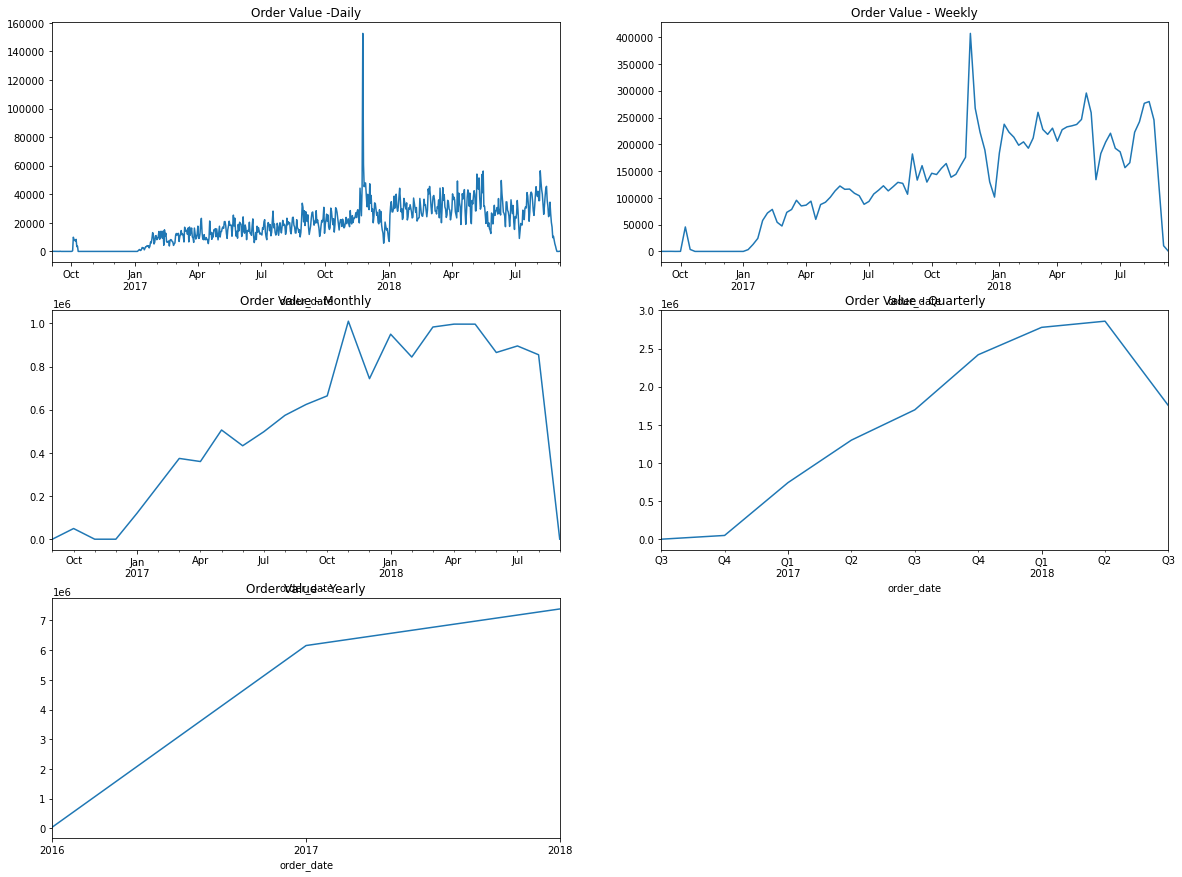

In [32]:
 plt.figure(figsize=(20,15))
plt.subplot(3,2,1,)
ts_daily.order_value.plot()
plt.title('Order Value -Daily');

plt.subplot(3,2,2)
ts_daily.resample('W').sum().order_value.plot()
plt.title('Order Value - Weekly');

plt.subplot(3,2,3)
ts_daily.resample('M').sum().order_value.plot()
plt.title('Order Value - Monthly');

plt.subplot(3,2,4)
ts_daily.resample('Q').sum().order_value.plot()
plt.title('Order Value - Quarterly');

plt.subplot(3,2,5)
ts_daily.resample('Y').sum().order_value.plot()
plt.title('Order Value - Yearly');

### order level volume (number of items) by period

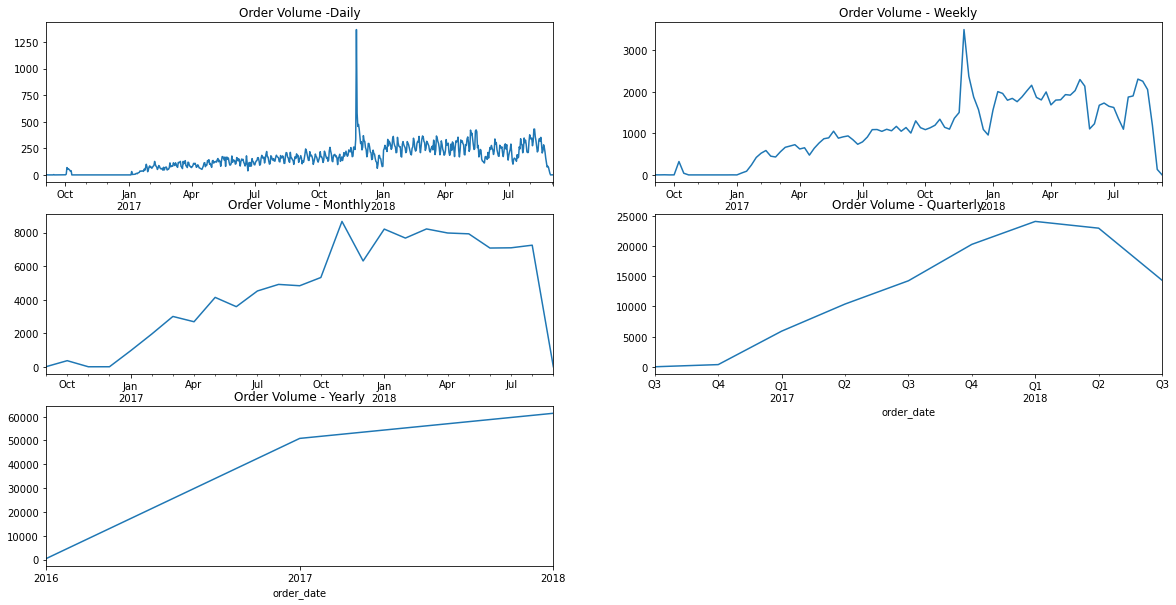

In [33]:
 plt.figure(figsize=(20,10))
plt.subplot(3,2,1,)
ts_daily.order_volume.plot()
plt.title('Order Volume -Daily');

plt.subplot(3,2,2)
ts_daily.resample('W').sum().order_volume.plot()
plt.title('Order Volume - Weekly');

plt.subplot(3,2,3)
ts_daily.resample('M').sum().order_volume.plot()
plt.title('Order Volume - Monthly');

plt.subplot(3,2,4)
ts_daily.resample('Q').sum().order_volume.plot()
plt.title('Order Volume - Quarterly');

plt.subplot(3,2,5)
ts_daily.resample('Y').sum().order_volume.plot()
plt.title('Order Volume - Yearly');

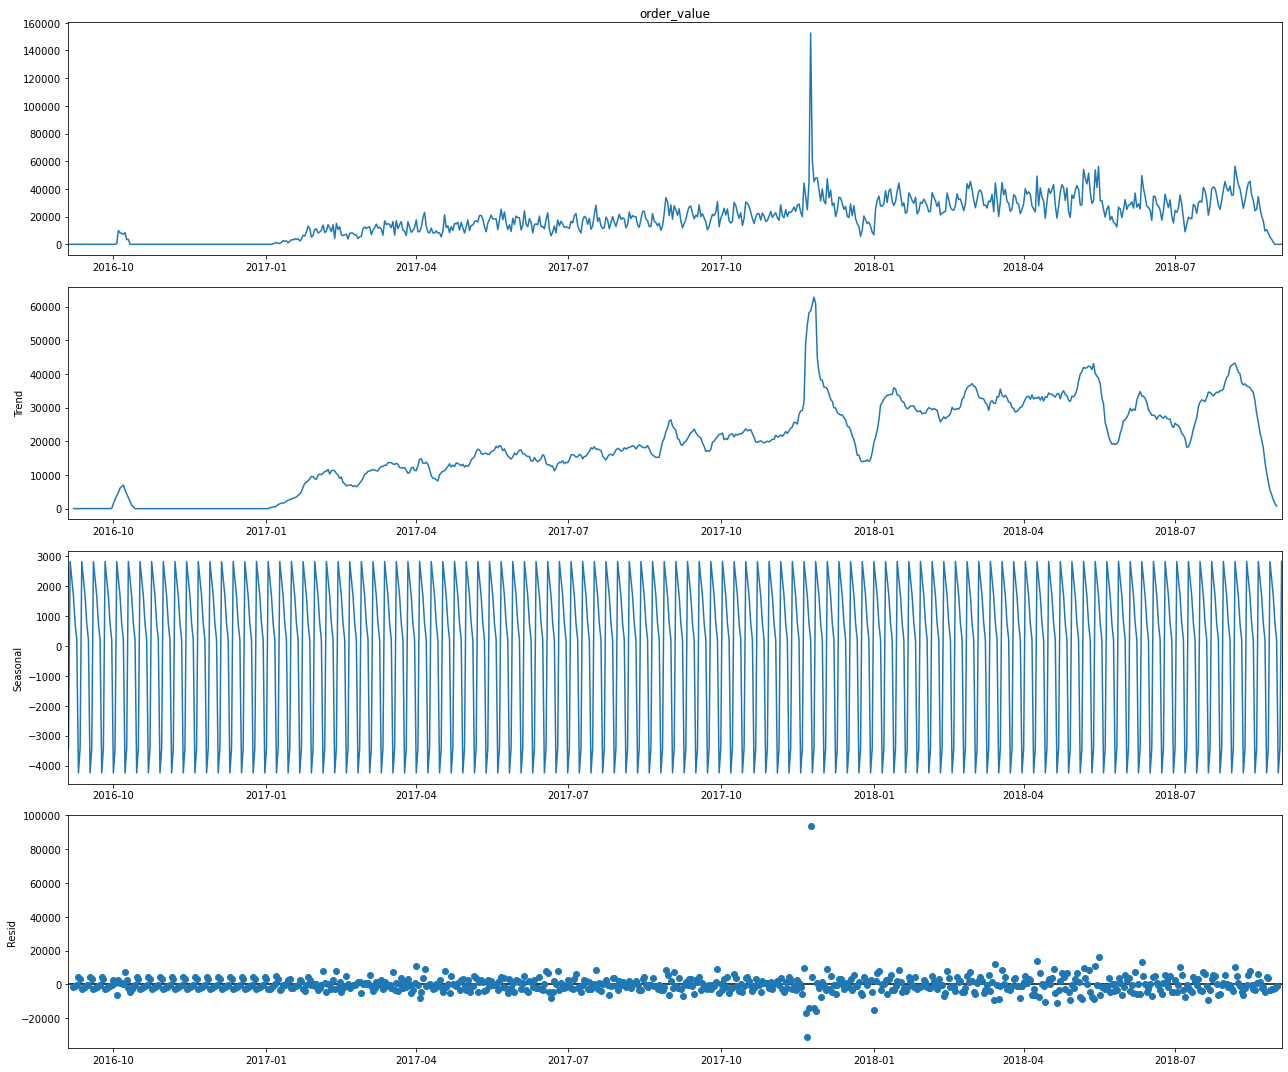

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 15

from statsmodels.tsa.seasonal import seasonal_decompose
series = ts_daily.order_value
result = seasonal_decompose(series, model='additive')
fig = result.plot()
plt.show()

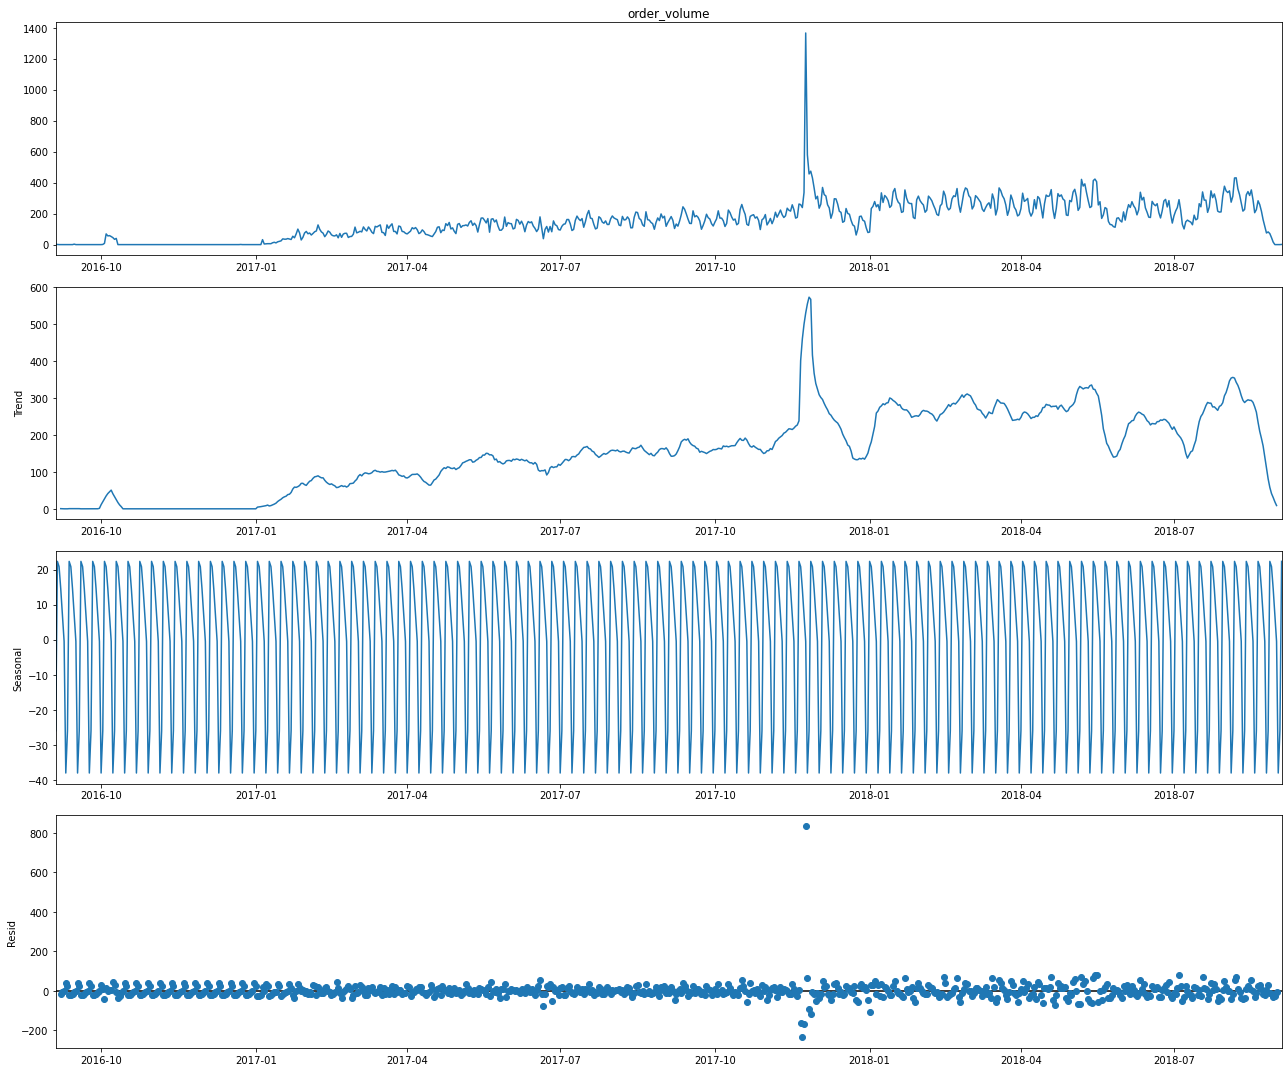

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 15

from statsmodels.tsa.seasonal import seasonal_decompose
series = ts_daily.order_volume
result = seasonal_decompose(series, model='additive')
fig = result.plot()
plt.show()

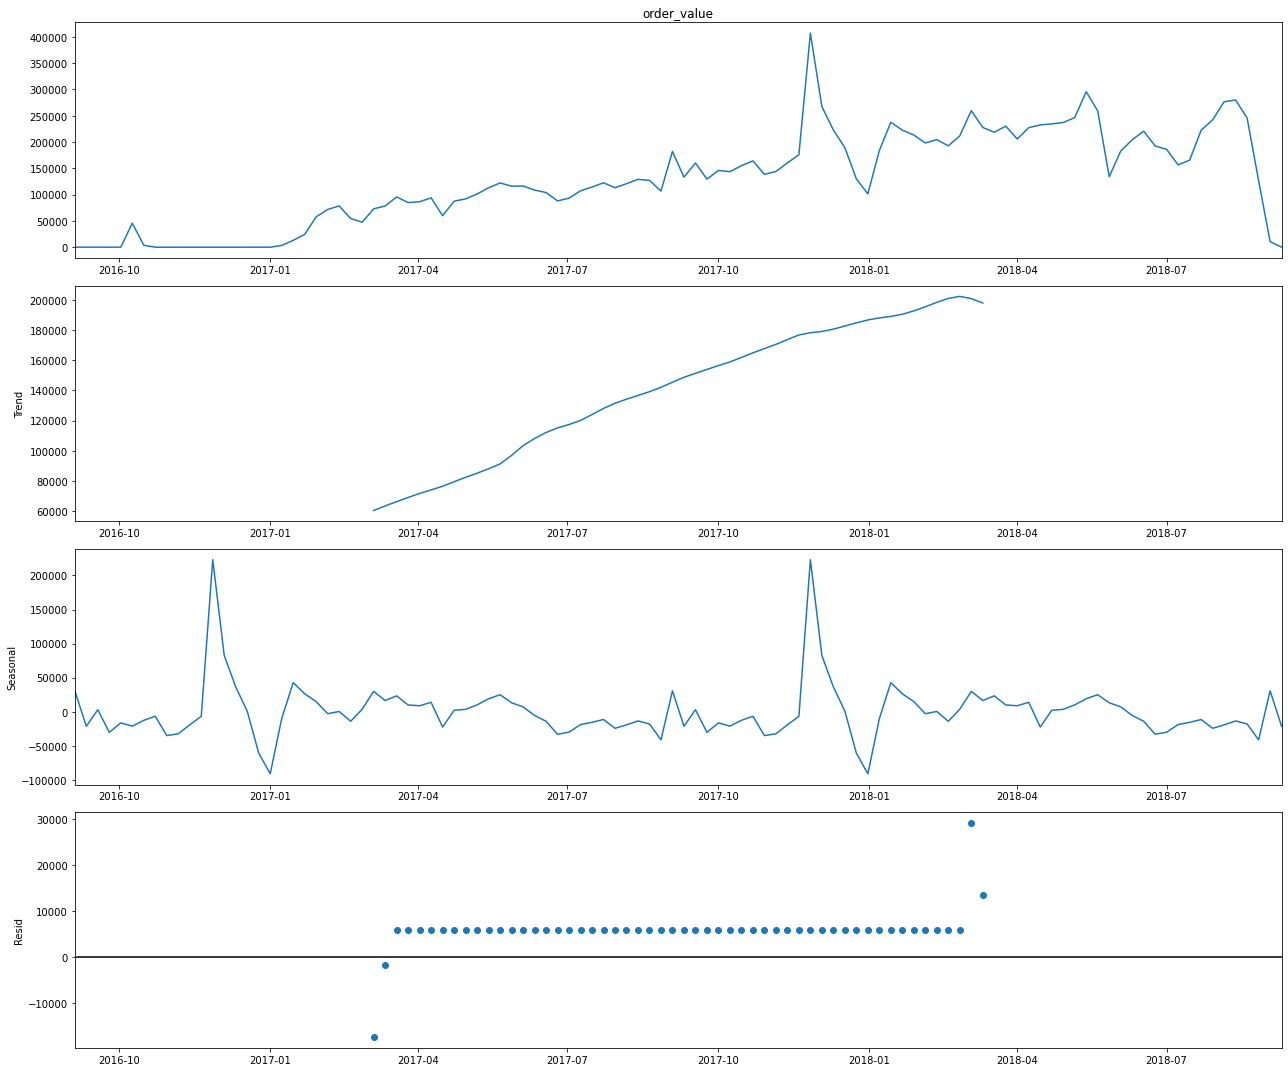

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 15

from statsmodels.tsa.seasonal import seasonal_decompose
series = ts_daily.resample('W').sum().order_value
result = seasonal_decompose(series, model='additive')
fig = result.plot()
plt.show()

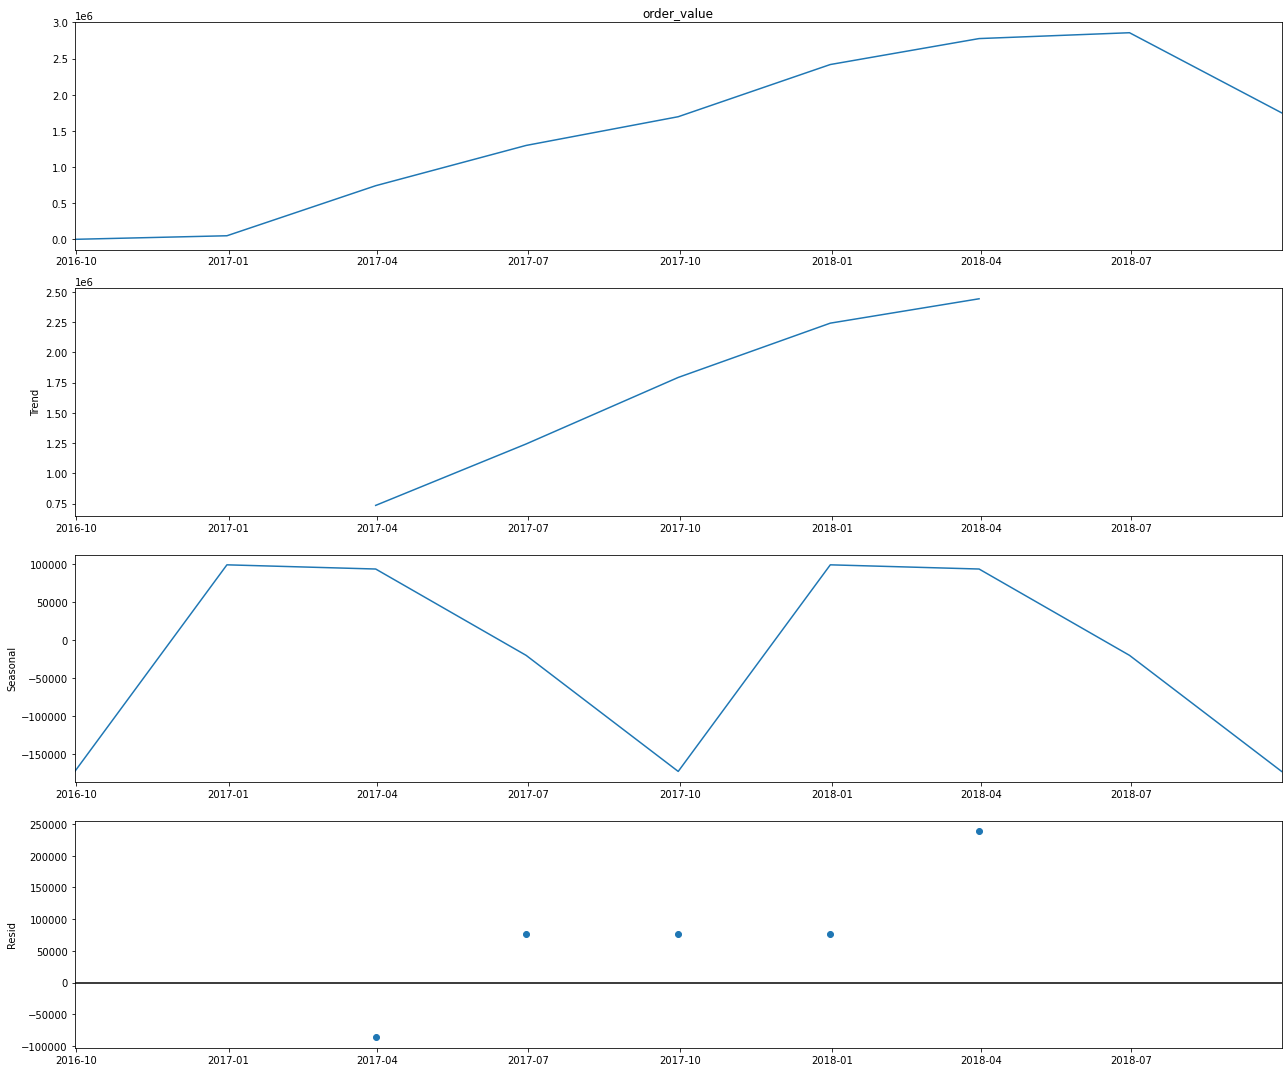

In [38]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 15

from statsmodels.tsa.seasonal import seasonal_decompose
series = ts_daily.resample('Q').sum().order_value
result = seasonal_decompose(series, model='additive')
fig = result.plot()
plt.show()

### Forecasting

#### Splitting data into training and test dataset. the last 30 days data has been extracted for prediction

In [184]:
#split ts_daily into training and test data set
training, test = ts_daily.iloc[:-30], ts_daily.iloc[-30:]

In [185]:
print( 'number of rows of training dataset -',len(training))
print( 'number of rows of test dataset -',len(test))
print( 'number of rows training +  test dataset -',len(test) + len(training))
print()
print('number of rows or entire dataset -', len(ts_daily))

number of rows of training dataset - 700
number of rows of test dataset - 30
number of rows training +  test dataset - 730

number of rows or entire dataset - 730


In [186]:
training.head(10)

,order_value,order_volume
order_date,,
2016-09-04,72.89,2
2016-09-05,59.50,1
2016-09-06,0.00,0
2016-09-07,0.00,0
2016-09-08,0.00,0
2016-09-09,0.00,0
2016-09-10,0.00,0
2016-09-11,0.00,0
2016-09-12,0.00,0


In [187]:
training.tail(10)

,order_value,order_volume
order_date,,
2018-07-26,35292.72,286
2018-07-27,28371.75,216
2018-07-28,25210.12,210
2018-07-29,31434.08,211
2018-07-30,39070.66,312
2018-07-31,45316.28,377
2018-08-01,40553.80,347
2018-08-02,38462.26,336
2018-08-03,42075.18,347


In [188]:
test.head(10)

,order_value,order_volume
order_date,,
2018-08-05,35583.76,312
2018-08-06,56427.39,430
2018-08-07,49178.98,431
2018-08-08,43333.07,360
2018-08-09,40040.28,322
2018-08-10,33424.73,268
2018-08-11,25960.93,216
2018-08-12,31524.21,227
2018-08-13,38613.13,321


In [189]:
test.tail(10)

,order_value,order_volume
order_date,,
2018-08-25,10599.41,75
2018-08-26,8070.71,82
2018-08-27,5345.91,71
2018-08-28,3673.91,45
2018-08-29,1546.04,16
2018-08-30,0.00,0
2018-08-31,0.00,0
2018-09-01,0.00,0
2018-09-02,0.00,0


#### Examining ACF and PACF

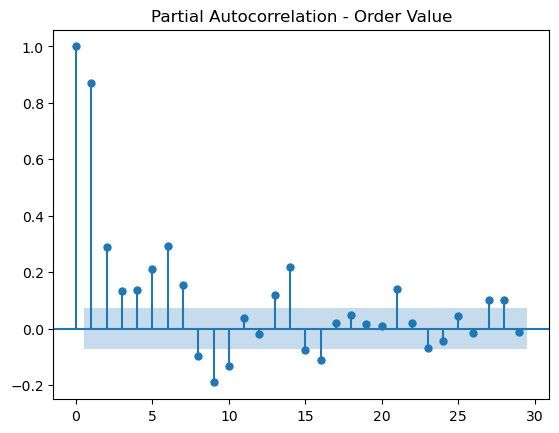

In [190]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(ts_daily.order_value, title='Partial Autocorrelation - Order Value' );



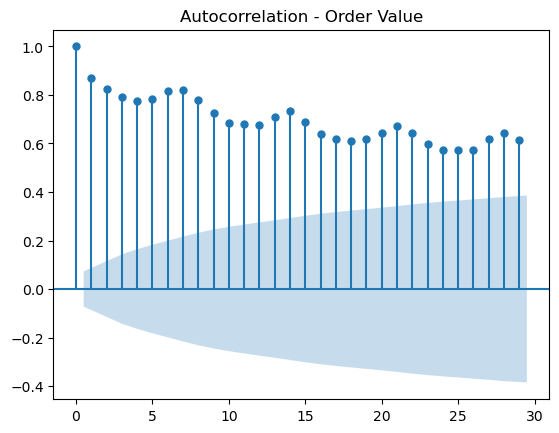

In [191]:
plot_acf(ts_daily.order_value, title='Autocorrelation - Order Value');

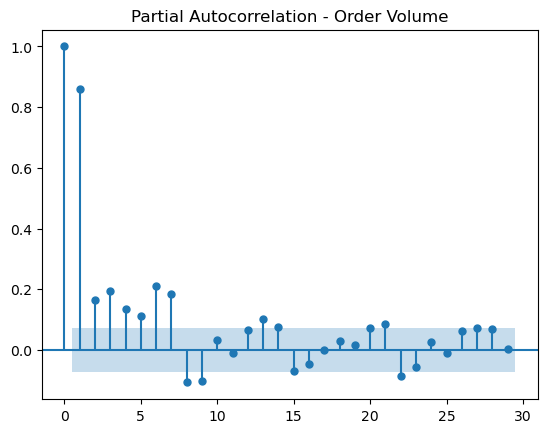

In [192]:
plot_pacf(ts_daily.order_volume, title='Partial Autocorrelation - Order Volume');

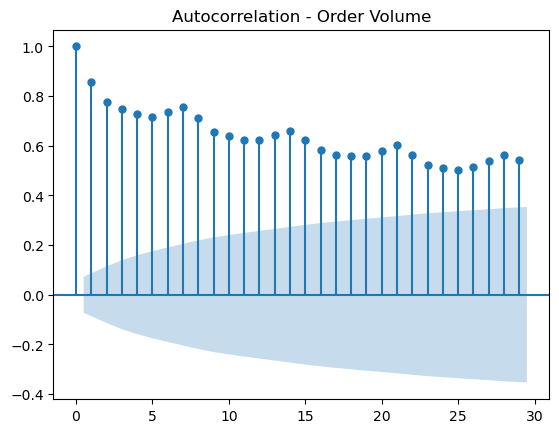

In [193]:
plot_acf(ts_daily.order_volume, title='Autocorrelation - Order Volume');

### Applying SARIMA model  - ORDER VALUE

In [194]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [195]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [196]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training.order_value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except ex:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:15985.84375982923
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15374.084390758573
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:15041.89696995933
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:14537.527878145349
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:14020.746828318872
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:13787.764421853784
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:14984.180003954729
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:14146.443685648375
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:13799.304165229034
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:14542.210062486196
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:14241.129240458773
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:14011.529360011042
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:14200.014486068168
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:14017.792791353882


NameError: name 'ex' is not defined

this configuration had the lowest AIC - ARIMA(0, 1, 1)x(0, 2, 2, 12)12 - AIC:13505.25281590296

In [197]:
mod = sm.tsa.statespace.SARIMAX(training.order_value,
                                order=(0, 1, 1),
                                seasonal_order=(0, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [198]:
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                             order_value   No. Observations:                  700
Model:             SARIMAX(0, 1, 1)x(0, 2, [1, 2], 12)   Log Likelihood               -6940.561
Date:                                 Wed, 10 Mar 2021   AIC                          13889.122
Time:                                         09:34:17   BIC                          13907.024
Sample:                                     09-04-2016   HQIC                         13896.067
                                          - 08-04-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7095      0.132     -5.380      0.000      -0.968      -0

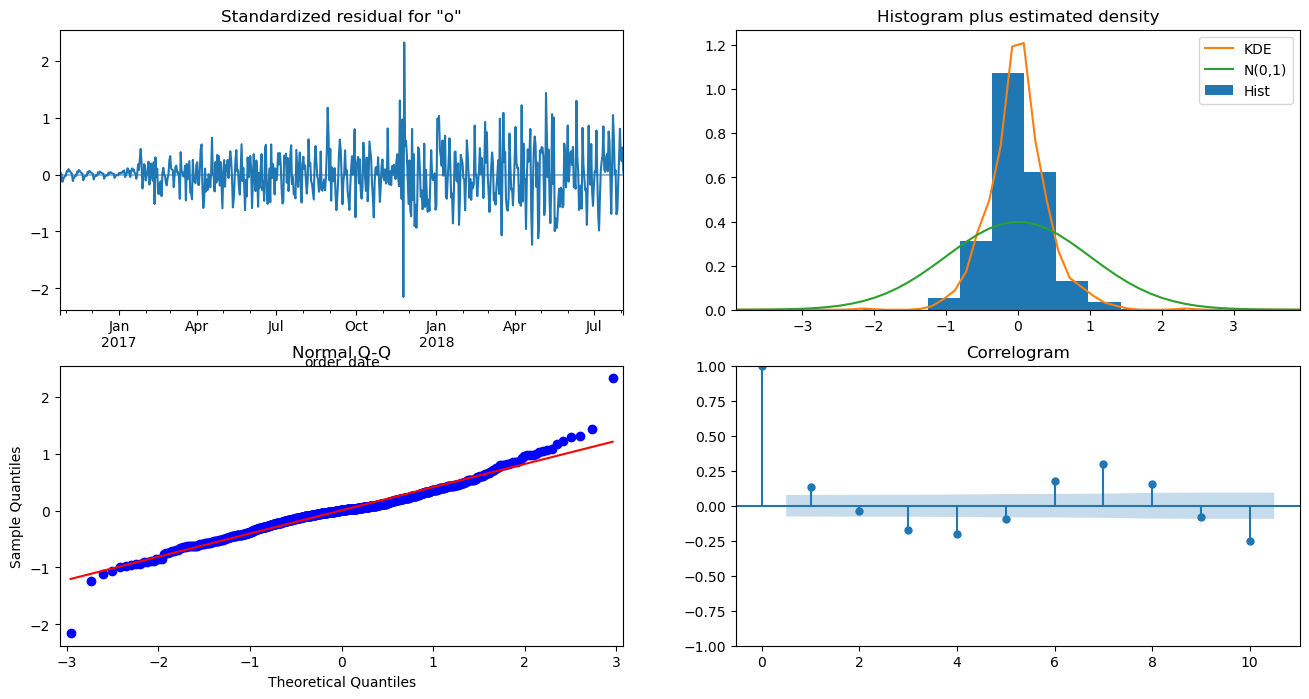

In [199]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Compare  forecast with the Actual Test dataset


In [200]:
number_of_days_to_forecast = 30

In [201]:
forecast_30days = results.get_forecast(number_of_days_to_forecast)


In [202]:
forecast_30days.predicted_mean

2018-08-05    38852.401322
2018-08-06    44242.371651
2018-08-07    37251.119087
2018-08-08    41421.648137
2018-08-09    40179.641426
2018-08-10    42692.094891
2018-08-11    44949.395272
2018-08-12    42833.220275
2018-08-13    40578.239148
2018-08-14    37860.290396
2018-08-15    37905.142195
2018-08-16    35419.807203
2018-08-17    40147.817146
2018-08-18    45489.321728
2018-08-19    37539.339726
2018-08-20    42100.237203
2018-08-21    40831.629064
2018-08-22    43489.308462
2018-08-23    46345.838608
2018-08-24    44399.244524
2018-08-25    41253.300677
2018-08-26    37899.007316
2018-08-27    38783.741270
2018-08-28    36049.148788
2018-08-29    41812.759194
2018-08-30    47105.798028
2018-08-31    38197.086589
2018-09-01    43148.352493
2018-09-02    41853.142925
2018-09-03    44656.048257
Freq: D, Name: predicted_mean, dtype: float64

In [203]:
order_value_results = test['order_value'][:number_of_days_to_forecast].reset_index().set_index('order_date')


In [204]:
order_value_results['forcast'] = forecast_30days.predicted_mean
order_value_results['lower order_value'] = forecast_30days.conf_int().iloc[:,0]
order_value_results['upper order_value'] = forecast_30days.conf_int().iloc[:,1]
order_value_results


,order_value,forcast,lower order_value,upper order_value
order_date,,,,
2018-08-05,35583.76,38852.401322,7326.319391,70378.483254
2018-08-06,56427.39,44242.371651,11413.114333,77071.628970
2018-08-07,49178.98,37251.119087,3168.590869,71333.647305
2018-08-08,43333.07,41421.648137,6130.356358,76712.939915
2018-08-09,40040.28,40179.641426,3719.645086,76639.637767
2018-08-10,33424.73,42692.094891,5099.709989,80284.479792
2018-08-11,25960.93,44949.395272,6257.744861,83641.045682
2018-08-12,31524.21,42833.220275,3072.671849,82593.768701
2018-08-13,38613.13,40578.239148,-223.218135,81379.696431


In [213]:
forecast_deviation_from_actual = (abs(test['order_value'][:number_of_days_to_forecast] -
                                      order_value_results['forcast']) / test['order_value'][:number_of_days_to_forecast])*100
forecast_deviation_from_actual = round(forecast_deviation_from_actual, 2) 

print ('% Deviation of forecast from Actual')
forecast_deviation_from_actual

% Deviation of forecast from Actual


order_date
2018-08-05        9.19
2018-08-06       21.59
2018-08-07       24.25
2018-08-08        4.41
2018-08-09        0.35
2018-08-10       27.73
2018-08-11       73.14
2018-08-12       35.87
2018-08-13        5.09
2018-08-14       14.33
2018-08-15       16.83
2018-08-16        0.70
2018-08-17       26.53
2018-08-18       86.88
2018-08-19       47.29
2018-08-20       22.10
2018-08-21       55.12
2018-08-22      114.26
2018-08-23      172.13
2018-08-24      360.88
2018-08-25      289.20
2018-08-26      369.59
2018-08-27      625.48
2018-08-28      881.22
2018-08-29     2604.51
2018-08-30         inf
2018-08-31         inf
2018-09-01         inf
2018-09-02         inf
2018-09-03    30697.27
Freq: D, dtype: float64

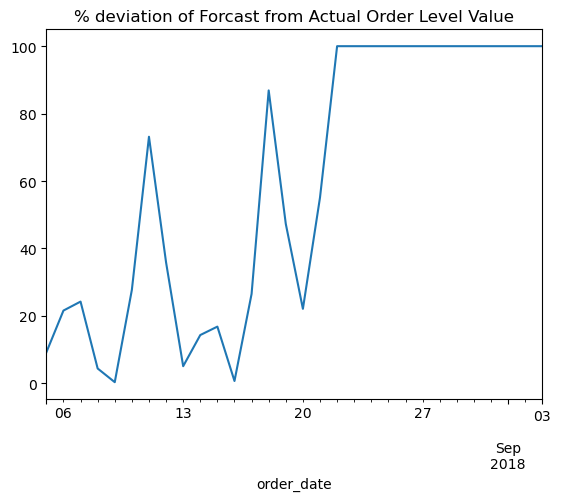

In [214]:
#replace any va`lue greater than 100% with 100%. 
forecast_deviation_from_actual[forecast_deviation_from_actual > 100 ] = 100
# forecast_deviation_from_actual = forecast_deviation_from_actual.replace(np.Inf, 5000)

forecast_deviation_from_actual.plot(title='% deviation of Forcast from Actual Order Level Value');

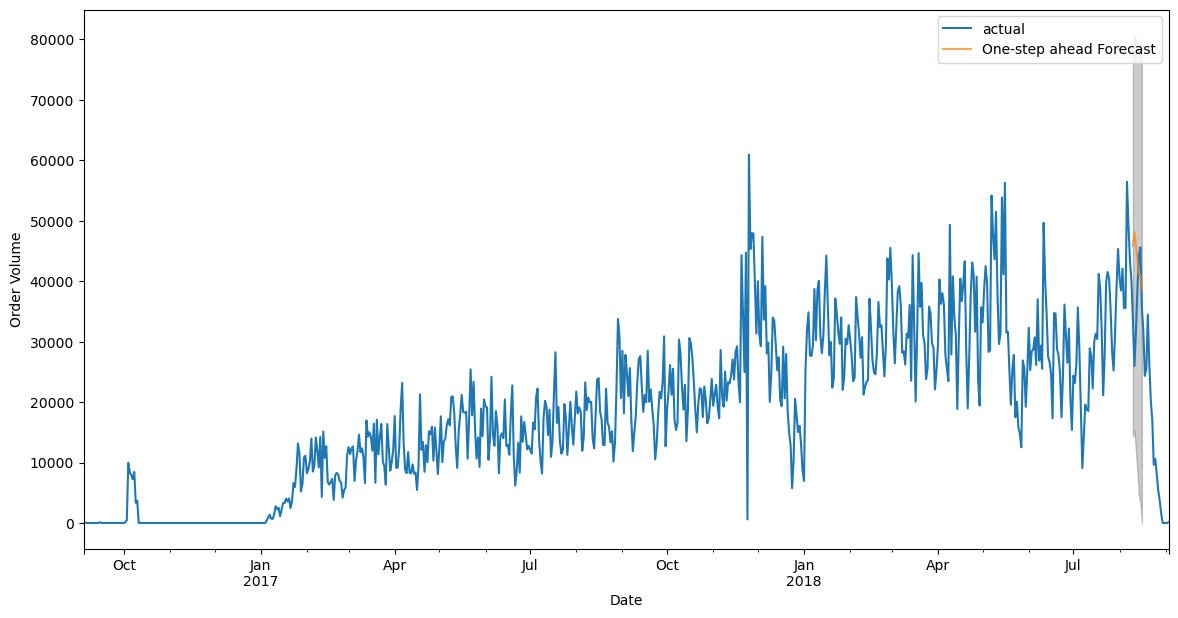

In [165]:

ax = ts_daily.order_value.plot(label='actual')
order_value_results['forcast'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(order_value_results.index,
                order_value_results['lower order_value'],
                order_value_results['upper order_value'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Volume')
plt.legend()
plt.show()

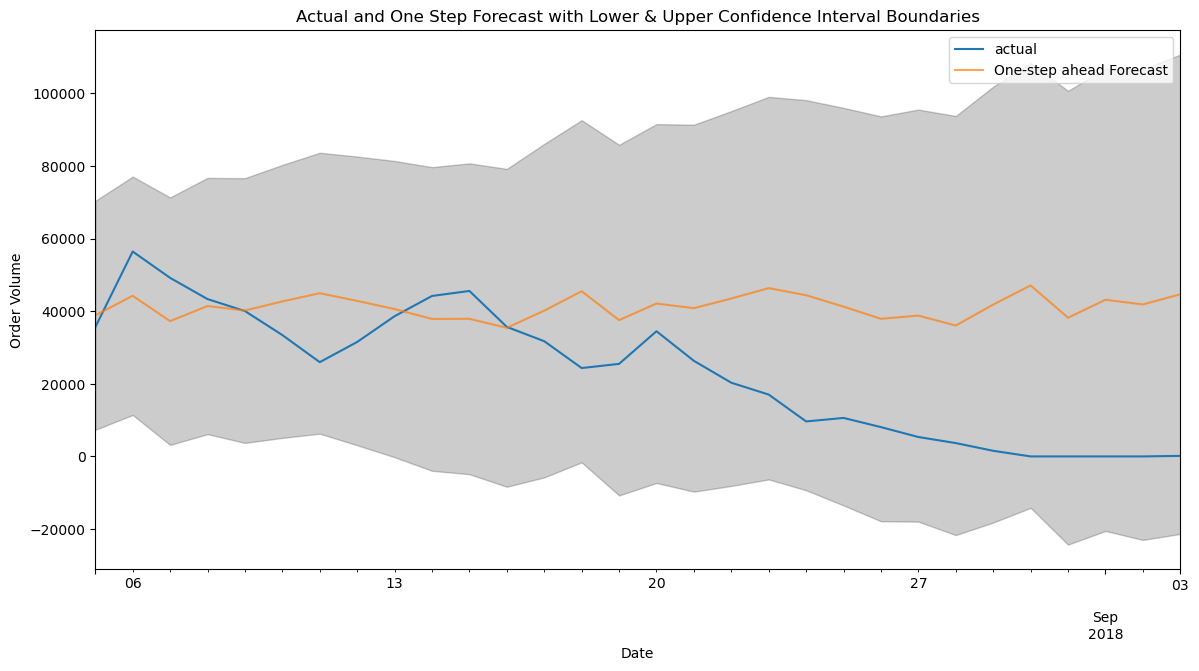

In [216]:
ax = order_value_results.order_value.plot(label='actual')
order_value_results['forcast'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(order_value_results.index,
                order_value_results['lower order_value'],
                order_value_results['upper order_value'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Volume')
plt.title('Actual and One Step Forecast with Lower & Upper Confidence Interval Boundaries')
plt.legend()
plt.show()

### Applying SARIMA model  - ORDER VOLUME

In [217]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training.order_volume,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except ex:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:9335.17416426842
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8745.175206835105
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:8389.1476503499
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:8217.299184144615
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7804.078311802326
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:7677.054960927179
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:8770.92681228009
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:7992.626895090416
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:7561.703163321468
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:8199.615745699306
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7929.186793724257
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:7803.704561683014
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7985.346586940376
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7806.061605202212
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:7675.106710611749
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:8363.866225246677
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:7887.40596890829
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:7563.307189574585
ARIMA(0, 0, 0)x

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:7567.595743179977
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:7548.176417079734
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:7461.559804223921
ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:7442.321988038877
ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:7844.360175472764
ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:7467.408451855426
ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:7346.47842813647
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:8336.802620160324
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:8085.242400961973
ARIMA(0, 0, 2)x(0, 0, 2, 12)12 - AIC:7865.831708013882
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:7981.528559598086
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:7506.146654065815
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:7382.639817984471
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:8574.64322310949
ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:7765.061126584607
ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:7290.572113815101
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:7934.613284620035
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:7630.848237488024
ARIMA(0, 0, 

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:7507.944010794805
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:7503.276723322353
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:7413.43650311947
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:7384.121876143243
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:7797.516289588619
ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:7424.33627335372


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:7294.387866639894
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:7767.708902834145
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:7644.975045422892
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:7525.204240771021
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:8162.781459800748
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:7560.184521159348
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:7436.085392922088
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:8782.596307482094
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:7942.1999383301045
ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:7400.815020041452
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:7655.082844655144
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:7646.939779480777
ARIMA(0, 1, 0)x(1, 0, 2, 12)12 - AIC:7527.158507553374
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:7820.159874035915
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:7560.220007311227
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:7435.5806026096125
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:8234.0761722781
ARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:7730.904081870538
ARIMA(0, 1

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:7245.504410905798
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:8389.232112643987
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:8257.815674860194
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:8124.2063160074285
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:8754.483149577216
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:8159.539573262267
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - AIC:8026.349188406826
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:9372.778767979917
ARIMA(0, 2, 0)x(0, 2, 1, 12)12 - AIC:8512.63485802571
ARIMA(0, 2, 0)x(0, 2, 2, 12)12 - AIC:7978.216618393121
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:8268.733179914092
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:8259.32321954446
ARIMA(0, 2, 0)x(1, 0, 2, 12)12 - AIC:8125.955791754558
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:8381.415467127805
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:8160.54788962464
ARIMA(0, 2, 0)x(1, 1, 2, 12)12 - AIC:8023.825885630911
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:8766.206329963594
ARIMA(0, 2, 0)x(1, 2, 1, 12)12 - AIC:8280.409305259716
ARIMA(0, 2, 

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 0)x(2, 2, 2, 12)12 - AIC:7979.641366234143
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:7754.878497301506
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:7632.2266624040785
ARIMA(0, 2, 1)x(0, 0, 2, 12)12 - AIC:7512.402963712379
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:8148.4120428885035
ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:7550.899117154401
ARIMA(0, 2, 1)x(0, 1, 2, 12)12 - AIC:7426.837734546765
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:8785.790489225474
ARIMA(0, 2, 1)x(0, 2, 1, 12)12 - AIC:7931.238570452913
ARIMA(0, 2, 1)x(0, 2, 2, 12)12 - AIC:7394.035805726362
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:7652.68133209255
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:7634.031612510359
ARIMA(0, 2, 1)x(1, 0, 2, 12)12 - AIC:7514.152242872839
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:7817.9811281356515
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:7552.304752842265
ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:7425.616441309078
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:8230.936904666542
ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:7721.70623574763


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:7395.656576713425
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:7532.543019021099
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:7534.45564931068


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(2, 0, 2, 12)12 - AIC:7516.072317113108
ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:7603.638462956406
ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:7448.615484809228


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(2, 1, 2, 12)12 - AIC:7427.491873819995
ARIMA(0, 2, 1)x(2, 2, 0, 12)12 - AIC:7900.498557679994
ARIMA(0, 2, 1)x(2, 2, 1, 12)12 - AIC:7531.116614864473


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1)x(2, 2, 2, 12)12 - AIC:7403.397518626978
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:7655.87066449082
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:7531.933614054529
ARIMA(0, 2, 2)x(0, 0, 2, 12)12 - AIC:7408.178955368852
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:8058.267229634785


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:7454.8996870148985
ARIMA(0, 2, 2)x(0, 1, 2, 12)12 - AIC:7329.377213560168
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:8656.068277456694
ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:7842.951693352405


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(0, 2, 2, 12)12 - AIC:7301.654811573919
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:7563.86023513585
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:7533.150148265029


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:7417.451380543582
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:7777.260968952333
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:7455.4779965753105


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:7333.940855056691
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:8199.987565459918
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:7669.3315001968


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 2, 2, 12)12 - AIC:7321.087101618713
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:7436.748377059872


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:7439.186600755894


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 0, 2, 12)12 - AIC:7426.197535000146
ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:7528.563219903171


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:7359.186609781182


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:7333.16926528278
ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:7863.068209418072


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:7457.780712736407


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:7996.10795841572
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:7761.725482152203
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:7641.298954649426
ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:7521.479868144283
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:7992.187611975963
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:7479.340265377647
ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:7356.0550935216015
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:8595.307602975958
ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:7777.343405542035
ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:7276.0133810855605
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:7641.145112693885
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:7604.987672130271
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:7484.580859691878
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:7675.4113066338605
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:7479.525368337563
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:7357.618564041151
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:8082.678152790213
ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:7598.145184448661
ARIMA(1,

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(2, 2, 2, 12)12 - AIC:7279.36195170986
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:7677.979489501084
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:7554.627878329826
ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:7431.219376343708
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:7982.076365467756
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:7463.30145976028
ARIMA(1, 0, 1)x(0, 1, 2, 12)12 - AIC:7342.067256281728
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:8582.259742621512
ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:7766.712182750911
ARIMA(1, 0, 1)x(0, 2, 2, 12)12 - AIC:7265.142706251853
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:7565.647438333787
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:7555.72154473227
ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:7432.79262100097
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:7676.651499302585
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:7462.8035384026225
ARIMA(1, 0, 1)x(1, 1, 2, 12)12 - AIC:7340.896901272564
ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:8079.589999163949
ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:7588.268687968572


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC:7266.182653616711
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:7438.852644306924
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:7440.756975398764


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:7411.110829982892
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:7462.297923039585
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:7347.27442265629
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:7338.013343783155
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:7767.429959085792
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:7385.326145732521


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:7268.502501466072
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:7611.545035607605
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:7491.279412714697
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:7370.665936319573
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:7962.377276362432
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:7405.411101892086
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:7283.465862826344
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:8562.197241581147
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:7747.269790031163


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:7243.316520636372
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:7511.636238186943
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:7492.558990236722


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:7372.590843095742
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:7672.00191395374
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:7405.556211116682
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:7284.247196309565
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:8076.955719749636
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:7572.8887402661785


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:7238.118781524469
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:7389.948776497582
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:7392.084064810136


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:7371.900687280444
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:7453.194715193247
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:7302.939265521822


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:7283.220624526024
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:7764.199990249537
ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:7376.778652870171


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:7486.505858181066
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:7728.764209127829
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:7604.4474942939505
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:7484.468377091962
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:8134.349172993272
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:7523.320413145342
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:7397.403553013812
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:8749.178080969954
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:7914.8137602104425
ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:7365.84933587333
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:7604.864328069251
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:7606.35817605744
ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:7486.247555212929
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:7791.614374897928
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:7522.072116492096
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:7398.674946538511
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:8210.885172242204
ARIMA(1, 1, 0)x(1, 2, 1, 12)12 - AIC:7713.254854485045
ARIMA(1, 1

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(2, 2, 2, 12)12 - AIC:7367.428539892815
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:7606.811218536625
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:7485.826051325352
ARIMA(1, 1, 1)x(0, 0, 2, 12)12 - AIC:7365.845699281087


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:7977.2251353876245
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:7403.732287582022
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:7281.302214017589
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:8588.152327886373
ARIMA(1, 1, 1)x(0, 2, 1, 12)12 - AIC:7766.7943626381575
ARIMA(1, 1, 1)x(0, 2, 2, 12)12 - AIC:7249.590665356537
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:7496.29597571975
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:7487.440609611362
ARIMA(1, 1, 1)x(1, 0, 2, 12)12 - AIC:7367.704101574814
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:7670.7768523772365
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:7404.115944506275
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:7282.547795713288
ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:8078.368551412991
ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:7588.782132924056


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:7322.3117143169175
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:7375.141808762401
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:7377.140834978205
ARIMA(1, 1, 1)x(2, 0, 2, 12)12 - AIC:7367.984335653022
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:7465.675388980967
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:7291.153310169718
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:7281.641511911268
ARIMA(1, 1, 1)x(2, 2, 0, 12)12 - AIC:7761.983193633881
ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:7390.682152385305


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:7397.424531931247
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:7597.1312637495685
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:7476.2540938732855
ARIMA(1, 1, 2)x(0, 0, 2, 12)12 - AIC:7356.479106658995
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:7966.94182980582
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:7394.349398653181
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:7271.883757467596
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:8565.630779730309
ARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:7801.766952634649


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(0, 2, 2, 12)12 - AIC:7254.480481972837
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:7496.5515960738585
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:7477.902588187719
ARIMA(1, 1, 2)x(1, 0, 2, 12)12 - AIC:7358.381533705195
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:7672.010598572036
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:7394.408148228714
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:7272.966392320437
ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:8075.43908945388


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:7582.363288973811


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:7256.323002192326
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:7375.860754402383
ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:7377.870352536989
ARIMA(1, 1, 2)x(2, 0, 2, 12)12 - AIC:7359.0954800107975
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:7456.9333981378
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:7291.847469896527


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:7272.260355625778
ARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:7763.334116307337
ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:7387.0057243711035


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:7248.017386061215
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:8163.76835108051
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:8029.957643332078
ARIMA(1, 2, 0)x(0, 0, 2, 12)12 - AIC:7902.539523672259
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:8573.19709411802
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:7942.808498891563
ARIMA(1, 2, 0)x(0, 1, 2, 12)12 - AIC:7807.182092952252
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:9198.241871400256
ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:8337.86060939952
ARIMA(1, 2, 0)x(0, 2, 2, 12)12 - AIC:7769.371310850433
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:8029.4653932124465
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:8031.391294955285
ARIMA(1, 2, 0)x(1, 0, 2, 12)12 - AIC:7904.510996694065
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:8182.060258885867
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:7938.388948101157
ARIMA(1, 2, 0)x(1, 1, 2, 12)12 - AIC:7806.305799109807
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:8595.64210570683
ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:8096.181542481821
ARIMA(1, 2, 0

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:7473.37732835325
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:7788.9749927698
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:7514.29594690036
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:7389.208975765279
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:8207.369181286163
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:7704.195125190723


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:7671.123912668581
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:7481.269370915148


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:7483.111102829736


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:7468.73994469167
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:7558.316610400222
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:7399.827965252496


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:7390.0513648377855
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:7872.786366502588
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:7486.29755348683


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:7764.793409335543
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:7625.419500604052
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:7502.149599600283


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:7490.093799719513
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:8120.517308789704


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:7543.567610689906


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:7302.183699373402
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:8637.212312918697


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:8060.153172691271


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:7256.491372005777
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:7496.062783176036
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:7504.491790718002


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 0, 2, 12)12 - AIC:7381.150971713343
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:7802.734273403725


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:7576.919079200306


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 1, 2, 12)12 - AIC:7487.647675805935


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:8272.662995389628


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:8139.310034373179


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 2, 12)12 - AIC:8017.941974881246


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:7508.374138315541


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:7400.96991705367


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 2, 12)12 - AIC:7511.550902953295


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:7488.889892707565


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:7409.593474598712


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 2, 12)12 - AIC:7514.047429119624


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:8115.815734670959


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:7991.71491905624


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 2, 12)12 - AIC:8024.232712923595
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:7719.877709725839
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:7607.806835560898
ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:7488.493629490984
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:7982.761176532725
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:7477.578916726754
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:7353.359958597555
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:8584.313330107647
ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:7778.52064995432
ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:7276.456261606625
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:7597.922270641157
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:7593.227092767005
ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:7482.460998950076
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:7666.42033694901
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:7466.954729366467
ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:7355.174065891153
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:8069.349220165224
ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:7588.403001435669
ARIMA(2, 0, 

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0)x(2, 2, 2, 12)12 - AIC:7322.228347609204
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:7630.912864598047
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:7500.895498017058
ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:7390.102440652154
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:7957.889141088156
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:7419.993997892148


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:7351.252416481322
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:8534.560769881216
ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:7747.565277187468


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:7743.453324957402
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:7510.7324687385935


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:7499.9735441019075


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:7393.399800386041
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:7664.653048828743


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:7413.838344709085


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:7358.919585770519
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:8045.362899361222


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:7595.3449220021375


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:7353.961260500834
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:7389.690693315089


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:7381.348838926373


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:7382.673616428017
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:7443.532112167541


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:7290.722039609917


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:7341.962832371079
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:7743.02365414718
ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:7378.389409621741


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 2, 2, 12)12 - AIC:7486.5567464160895
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:7610.190343448083
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:7488.585907790719
ARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:7369.0227358114325
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:7964.398763390111
ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:7403.863412319782


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 1, 2, 12)12 - AIC:7290.613717099546
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:8563.003163945607


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:7758.203966505412


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 2, 2, 12)12 - AIC:7555.619853487412
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:7499.415082806163


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:7490.275256648663


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 2, 12)12 - AIC:7370.91980273805
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:7659.773234468654


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:7403.652133067564


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:7282.593613148809
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:8064.955434058725


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:7571.268214224388


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 2, 2, 12)12 - AIC:7704.7911326598405
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:7378.449885638671


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:7380.60650388706


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:7371.792524065466
ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:7442.976697297997


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:7290.891824963164


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 2, 12)12 - AIC:7281.8829771837545


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:7746.303508439498


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:7717.193086954771


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 2, 12)12 - AIC:7715.014880808812
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:7679.281180198638
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:7568.7865334227545
ARIMA(2, 1, 0)x(0, 0, 2, 12)12 - AIC:7446.5597946145335
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:8060.182144443079
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:7485.66836139132
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:7362.907665713448
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:8654.881967954909
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:7853.626638714429
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:7330.358037266602
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:7559.11194797378
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:7560.33830147538
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:7448.437889141348
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:7749.830419878596
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:7475.852559160685
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:7364.28542273277
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:8159.137746508638
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:7671.251034111046


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:7331.6309882600435
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:7435.439303785117
ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:7437.385835581328
ARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:7410.682233178455
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:7518.7162943196145
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:7351.212340013062
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:7351.6678731537295
ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:7835.656869717168
ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:7441.758788228468


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:7391.353081293888
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:7607.264132477363
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:7486.05127667771
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:7366.503388290952
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:7978.442045804919
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:7404.4481635963875
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:7281.62221579144
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:8579.561027696582
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:7768.017246049259
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:7250.030386459446
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:7486.504004991561
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:7487.725564287335
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:7368.39688615619
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:7661.600641350666
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:7404.503797188776
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:7282.766094909648
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:8084.764305852123
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:7590.147333455402


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:7408.309833496251
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:7365.934975455004
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:7367.934626253758
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:7369.18614691535
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:7446.968414681511
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:7281.590000777557
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:7282.384210829212
ARIMA(2, 1, 1)x(2, 2, 0, 12)12 - AIC:7767.940871049842
ARIMA(2, 1, 1)x(2, 2, 1, 12)12 - AIC:7376.405719790373


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:7255.610357405506
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:7602.124520729276


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:7478.856768532389


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:7358.771795680539
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:7941.888089161558


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:7392.37247366116


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:7279.256717806767
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:8517.861431854079
ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:7736.622927132744
ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:7399.366794677733
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:7491.936408791311


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:7481.758485244207


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:7360.546962462458


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:7663.050183039284


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:7444.354545637747


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:7301.432299282098


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:8094.226924657768


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:7578.089816032443


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:7249.749199686961


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:7368.115571619941


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:7369.866271233115
ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:7362.555233649115
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:7456.251037919945


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:7279.820251272384


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:7275.370095406533


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:7751.202379943049


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:7382.250928255705


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:7257.08181503045
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:8021.98821334243
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:7905.926394569915
ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:7779.92500752073
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:8395.35108752127
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:7816.982433941648
ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:7688.079474905266
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:8989.523565189053
ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:8177.203817103693
ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:7649.858996208705
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:7895.609002760955
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:7897.258974662642
ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:7781.852574608022
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:8070.108545730048
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:7806.260582643081
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:7689.340354021916
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:8470.744148222067
ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:7985.154585312645
ARIMA(2, 2, 0)

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 0)x(2, 2, 2, 12)12 - AIC:7641.366141810386
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:7677.6070505154385


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:7556.201224941851
ARIMA(2, 2, 1)x(0, 0, 2, 12)12 - AIC:7434.054813826857
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:8057.311450682366
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:7476.650973783015
ARIMA(2, 2, 1)x(0, 1, 2, 12)12 - AIC:7353.869784961949
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:8650.88901989046
ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:7843.061011377889


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(0, 2, 2, 12)12 - AIC:7323.74457051146
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:7556.4761580662835
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:7558.119436201332
ARIMA(2, 2, 1)x(1, 0, 2, 12)12 - AIC:7435.742778957232
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:7747.0704382402955
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:7478.41596444934
ARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:7354.524359421892
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:8155.584475532292
ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:7673.645456908667


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:7325.503473687693
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:7432.853513166811
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:7434.688394158408


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 0, 2, 12)12 - AIC:7407.588697046363
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:7516.245222760499
ARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:7354.183268823932


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 1, 2, 12)12 - AIC:7357.1251837579275
ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:7832.34144642131
ARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:7444.312853689551


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1)x(2, 2, 2, 12)12 - AIC:7327.461975711159


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:7620.074746944809


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:7497.879677686209


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 0, 2, 12)12 - AIC:7378.021378191414
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:8076.447835331666


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:7397.7184657883645


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:7520.367349137675
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:8624.19637870517


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:7881.193016108167


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:7535.937694604705


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:7492.572476716488


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:7482.712814724797
ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:7378.460794508788


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:7745.9744520356035


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:7662.433315852864


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:7445.397065286908


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:8125.193907187068


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:8141.199740550541


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:7991.526367259424


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:7386.128912753774


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:7388.307205616608


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:7379.835434527901


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:7587.851644919318


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:7534.532029232776


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:7520.9502291564095


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:8086.202376464418


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:7986.488313266384


C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:7990.663165736623


this configuration had the lowest AIC - ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:7249.749199686961

In [219]:
mod = sm.tsa.statespace.SARIMAX(training.order_volume,
                                order=(2, 1, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

C:\Users\ADEBAYO ADERIBIGBE\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [220]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       order_volume   No. Observations:                  700
Model:             SARIMAX(2, 1, 2)x(1, 2, 2, 12)   Log Likelihood               -3616.875
Date:                            Wed, 10 Mar 2021   AIC                           7249.749
Time:                                    13:28:49   BIC                           7285.540
Sample:                                09-04-2016   HQIC                          7263.634
                                     - 08-04-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4978      0.111     13.442      0.000       1.279       1.716
ar.L2         -0.5189      0.075   

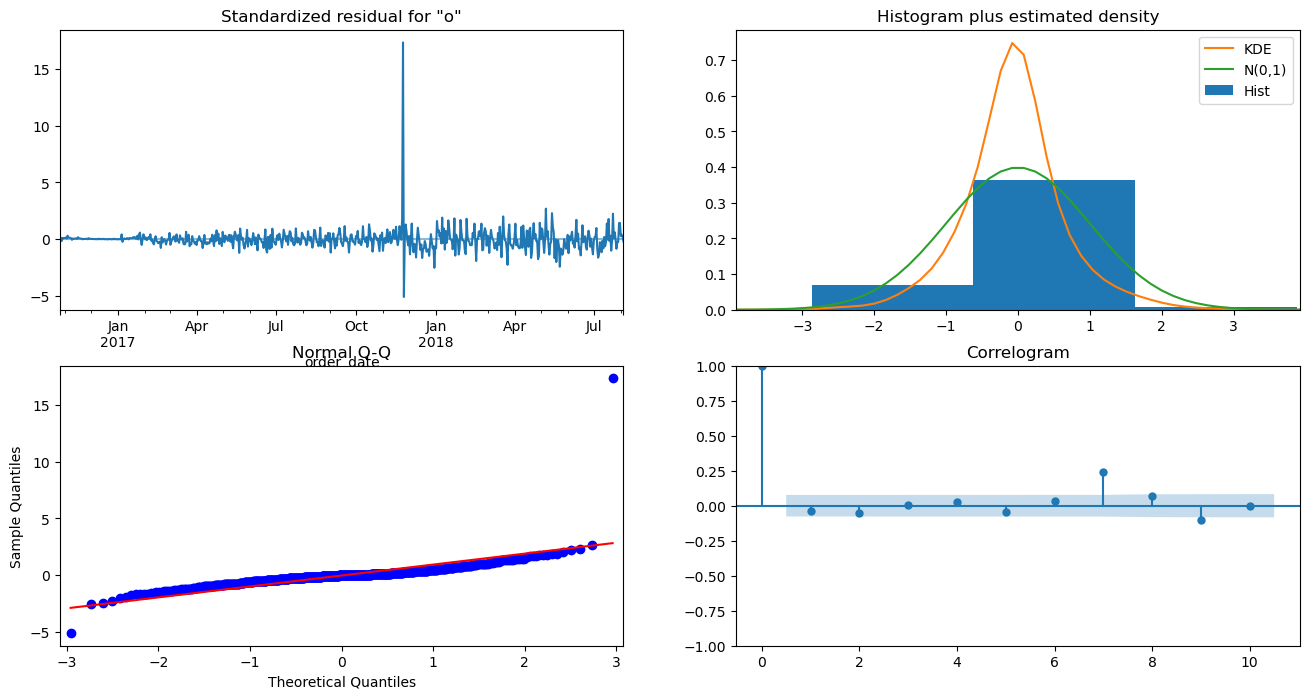

In [221]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Compare  forecast with the Actual Test dataset


In [222]:
number_of_days_to_forecast = 30

In [223]:
forecast_30days = results.get_forecast(number_of_days_to_forecast)


In [224]:
forecast_30days.predicted_mean

2018-08-05    266.721842
2018-08-06    279.831451
2018-08-07    267.716411
2018-08-08    262.315537
2018-08-09    259.210683
2018-08-10    261.350662
2018-08-11    265.983126
2018-08-12    272.435873
2018-08-13    275.136200
2018-08-14    272.711018
2018-08-15    299.730073
2018-08-16    259.683338
2018-08-17    257.745059
2018-08-18    274.643219
2018-08-19    263.775747
2018-08-20    258.250570
2018-08-21    255.922600
2018-08-22    258.409394
2018-08-23    264.752915
2018-08-24    272.483251
2018-08-25    274.669382
2018-08-26    271.914824
2018-08-27    298.903657
2018-08-28    258.002378
2018-08-29    256.111212
2018-08-30    273.450376
2018-08-31    262.486998
2018-09-01    256.782573
2018-09-02    254.717835
2018-09-03    257.248140
Freq: D, Name: predicted_mean, dtype: float64

In [227]:
order_volume_results = test['order_volume'][:number_of_days_to_forecast].reset_index().set_index('order_date')


In [228]:
order_volume_results['forcast'] = forecast_30days.predicted_mean
order_volume_results['lower order_volume'] = forecast_30days.conf_int().iloc[:,0]
order_volume_results['upper order_volume'] = forecast_30days.conf_int().iloc[:,1]
order_volume_results


,order_volume,forcast,lower order_volume,upper order_volume
order_date,,,,
2018-08-05,312,266.721842,145.989268,387.454416
2018-08-06,430,279.831451,139.483617,420.179286
2018-08-07,431,267.716411,120.442453,414.990368
2018-08-08,360,262.315537,112.054861,412.576213
2018-08-09,322,259.210683,107.408366,411.013000
2018-08-10,268,261.350662,108.606040,414.095284
2018-08-11,216,265.983126,112.574081,419.392172
2018-08-12,227,272.435873,118.505215,426.366530
2018-08-13,321,275.136200,120.764503,429.507896


In [229]:
forecast_deviation_from_actual = (abs(test['order_volume'][:number_of_days_to_forecast] -
                                      order_volume_results['forcast']) / test['order_volume'][:number_of_days_to_forecast])*100
forecast_deviation_from_actual = round(forecast_deviation_from_actual, 2) 

print ('% Deviation of forecast from Actual')
forecast_deviation_from_actual

% Deviation of forecast from Actual


order_date
2018-08-05       14.51
2018-08-06       34.92
2018-08-07       37.88
2018-08-08       27.13
2018-08-09       19.50
2018-08-10        2.48
2018-08-11       23.14
2018-08-12       20.02
2018-08-13       14.29
2018-08-14       20.26
2018-08-15        5.45
2018-08-16       26.44
2018-08-17       10.81
2018-08-18       33.32
2018-08-19       16.71
2018-08-20        8.75
2018-08-21        0.81
2018-08-22       19.63
2018-08-23       64.44
2018-08-24      132.89
2018-08-25      266.23
2018-08-26      231.60
2018-08-27      320.99
2018-08-28      473.34
2018-08-29     1500.70
2018-08-30         inf
2018-08-31         inf
2018-09-01         inf
2018-09-02         inf
2018-09-03    25624.81
Freq: D, dtype: float64

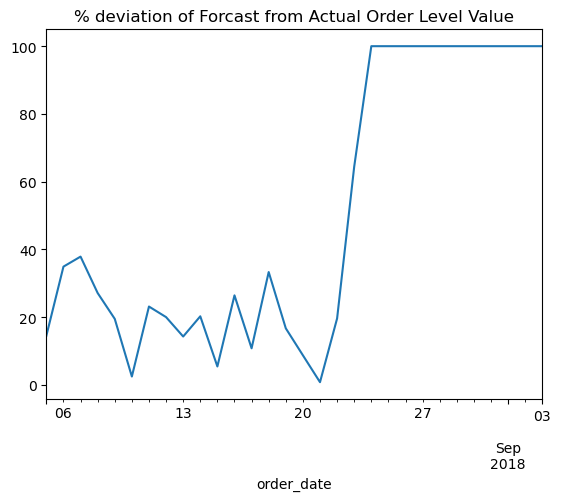

In [230]:
#replace any va`lue greater than 100% with 100%. 
forecast_deviation_from_actual[forecast_deviation_from_actual > 100 ] = 100
# forecast_deviation_from_actual = forecast_deviation_from_actual.replace(np.Inf, 5000)

forecast_deviation_from_actual.plot(title='% deviation of Forcast from Actual Order Level Value');

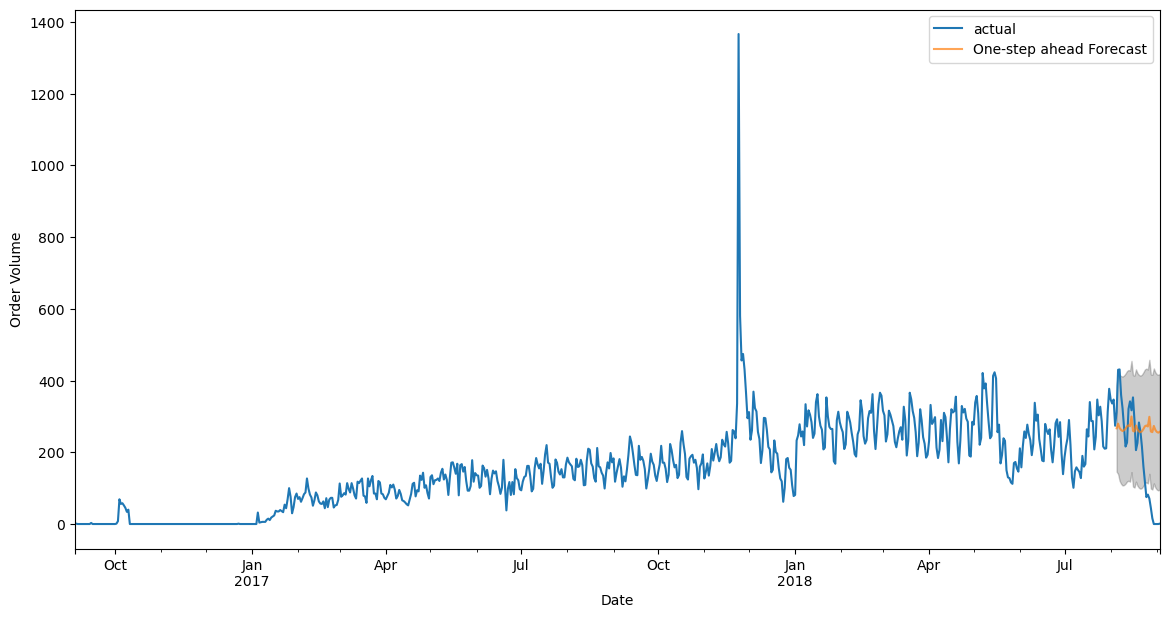

In [234]:

ax = ts_daily.order_volume.plot(label='actual')
order_volume_results['forcast'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(order_volume_results.index,
                order_volume_results['lower order_volume'],
                order_volume_results['upper order_volume'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Volume')
plt.legend()
plt.show()

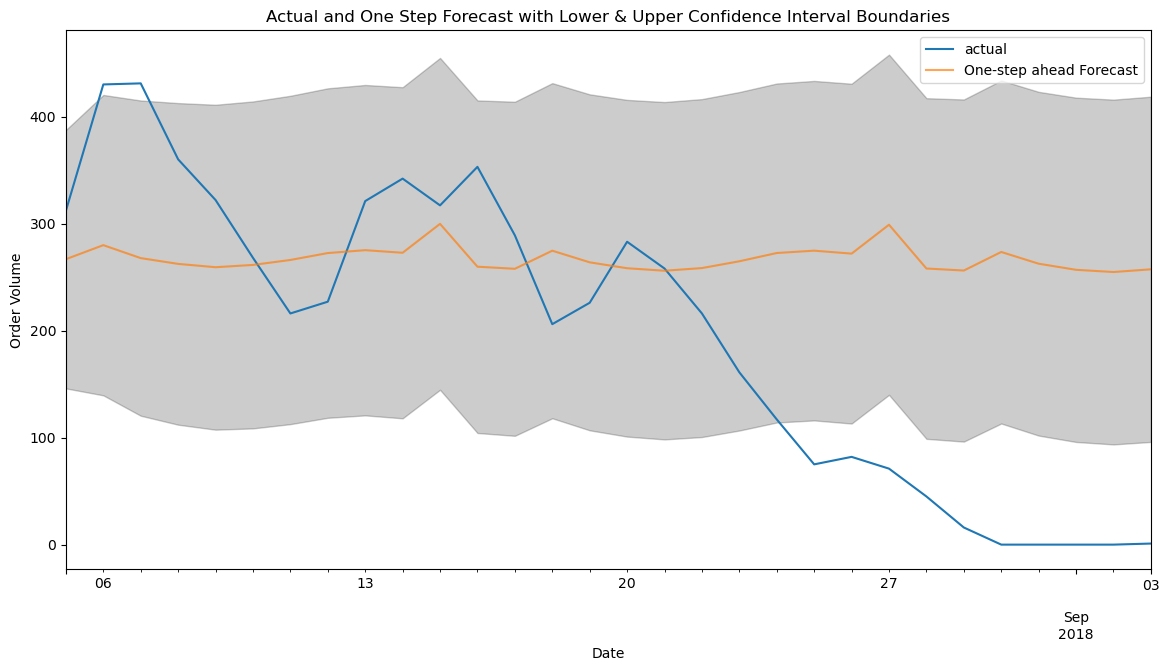

In [236]:
ax = order_volume_results.order_volume.plot(label='actual')
order_value_results['forcast'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(order_volume_results.index,
                order_volume_results['lower order_volume'],
                order_volume_results['upper order_volume'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order Volume')
plt.title('Actual and One Step Forecast with Lower & Upper Confidence Interval Boundaries')
plt.legend()
plt.show()